In [38]:
import numpy as np
import gzip
import matplotlib.pyplot as plt

data_of_interest = '../snps_of_interest'

ihart_data_dir = '../split_gen_miss'
ihart_ped_file = '../data/160826.ped'
ihart_pvalue_dir = '../parental_differences_ihart'

ssc_data_dir = '../split_gen_miss_ssc'
ssc_ped_file = '../data/ssc.ped'
ssc_pvalue_dir = '../parental_differences_ssc'

bonferonni_cutoff = 11
chroms = [str(x) for x in range(1, 23)]

In [50]:
# pull indices of moms, dads, daughters, and sons

def pull_family_indices(data_dir, ped_file):
    mom_indices, dad_indices = set(), set()
    daughter_indices, son_indices = set(), set()
    autism_indices, noautism_indices = set(), set()

    with open('%s/chr.%s.gen.samples.txt' % (data_dir, chrom), 'r') as f:
        sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 5:
                if pieces[5] == '2':
                    if pieces[3] in sample_id_to_index:
                        mom_indices.add(sample_id_to_index[pieces[3]])
                    if pieces[2] in sample_id_to_index:
                        dad_indices.add(sample_id_to_index[pieces[2]])
                if pieces[1] in sample_id_to_index:
                    if pieces[4] == '2':
                        daughter_indices.add(sample_id_to_index[pieces[1]])
                    elif pieces[4] == '1':
                        son_indices.add(sample_id_to_index[pieces[1]])
                    if pieces[5] == '2':
                        autism_indices.add(sample_id_to_index[pieces[1]])
                    elif pieces[5] == '1':
                        noautism_indices.add(sample_id_to_index[pieces[1]])

    daughter_indices = daughter_indices - mom_indices
    son_indices = son_indices - dad_indices

    autism_indices = autism_indices & (daughter_indices | son_indices)
    noautism_indices = noautism_indices & (daughter_indices | son_indices)
    
    print('Moms', len(mom_indices), 'Dads', len(dad_indices))
    print('Daughters', len(daughter_indices), 'Sons', len(son_indices))
    print('Autism', len(autism_indices), 'No autism', len(noautism_indices))
    return mom_indices, dad_indices, daughter_indices, son_indices, autism_indices, noautism_indices

print('iHART')
ihart_mom_indices, ihart_dad_indices, ihart_daughter_indices, ihart_son_indices, ihart_autism_indices, ihart_noautism_indices = pull_family_indices(ihart_data_dir, ihart_ped_file)

print('\nSSC')
ssc_mom_indices, ssc_dad_indices, ssc_daughter_indices, ssc_son_indices, ssc_autism_indices, ssc_noautism_indices = pull_family_indices(ssc_data_dir, ssc_ped_file)


iHART
Moms 996 Dads 896
Daughters 777 Sons 1927
Autism 2179 No autism 525

SSC
Moms 518 Dads 518
Daughters 315 Sons 691
Autism 510 No autism 496


# Now let's take a look at VCFs

In [155]:
# First, pull positions of interest from file
positions_of_interest = []
with open('%s/sex_gwas_sig_ihart_ssc.txt' % data_of_interest) as f:
    for line in f:
        chrom, pos = line.strip().split('\t')
        positions_of_interest.append((chrom, int(pos)))

n = len(positions_of_interest)
positions_of_interest.sort(key=lambda x:(int(x[0]), x[1]))
pos_to_index = dict([(p, i) for i, p in enumerate(positions_of_interest)])
print('Positions', n)

Positions 6091


In [156]:
# Next, pull pvalues for these positions

def pull_pvalues(positions_of_interest, data_dir, pvalue_dir):
    pvalues_of_interest = -np.ones((n, 4), dtype=int)
    for chrom in chroms:
        print(chrom, end=' ')
        # pull snp positions
        pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
        snp_positions = pos_data[:, 1]
        is_snp = pos_data[:, 2].astype(bool)
        snp_positions = snp_positions[is_snp]

        # pull log pvalues
        log_pvalues = np.load('%s/chr.%s.logpvalues.npy' % (pvalue_dir, chrom))

        for i, p in enumerate(snp_positions):
            if (chrom, p) in pos_to_index:
                pvalues_of_interest[pos_to_index[(chrom, p)], :] = log_pvalues[i, :]
        
    return pvalues_of_interest

ihart_pvalue_of_interest = pull_pvalues(positions_of_interest, ihart_data_dir, ihart_pvalue_dir)
ssc_pvalue_of_interest = pull_pvalues(positions_of_interest, ssc_data_dir, ssc_pvalue_dir)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [157]:
ihart_indices = np.where(np.any(ihart_pvalue_of_interest>bonferonni_cutoff, axis=1))[0]
ssc_indices = np.where(np.any(ssc_pvalue_of_interest>bonferonni_cutoff, axis=1))[0]
print('iHART', ihart_indices.shape[0], 'SSC', ssc_indices.shape[0])

iHART 4774 SSC 3693


In [158]:
# Pull data from VCF

def convert_gt(gt):
    if gt == './.':
        return -1
    elif gt == '0/0' or gt == '0|0':
        return 0
    elif gt == '0/1' or gt == '1/0' or gt == '0|1' or gt == '1|0':
        return 1
    elif gt == '1/1' or gt == '1|1':
        return 2
    else:
        raise ValueError(gt)
        
def convert_dp(dp):
    if dp == '.':
        return -1
    else:
        return int(dp)
    
def convert_ad(ad):
    if ad == '.':
        return (-1, -1)
    else:
        ad1, ad2 = ad.split(',')
        return (int(ad1), int(ad2))
    
def convert_gq(gq):
    if gq == '.':
        return -1
    else:
        return int(gq)

def pull_vcf(dataset):
    
    # find num samples = m
    with gzip.open('%s/sex_gwas_%s%s.vcf.gz' % (data_of_interest, dataset, chroms[0]), 'rt') as f:
        # skip header
        line = next(f)
        while line.startswith('##'):
            line = next(f)
        m = len(line.strip().split('\t'))-9
    
    is_pass = np.zeros((n,), dtype=bool)
    gt = np.zeros((m, n), dtype=int)
    dp = np.zeros((m, n), dtype=int)
    ad = np.zeros((m, n, 2), dtype=int)
    gq = np.zeros((m, n), dtype=int)
    nearby_genes = [None]*n
    
    for chrom in chroms:
        print(chrom, end=' ')
        with gzip.open('%s/sex_gwas_%s%s.vcf.gz' % (data_of_interest, dataset, chrom), 'rt') as f:
            
            # skip header
            line = next(f)
            while line.startswith('#'):
                line = next(f)
                
            for line in f:
                pieces = line.strip().split('\t')
                chrom, pos, _, ref, alt, _, pa  = pieces[:7]
                is_biallelic_snp = True if len(ref) == 1 and len(alt) == 1 and ref != '.' and alt != '.' else False
                
                if is_biallelic_snp:
                    i = pos_to_index[(chrom, int(pos))]
                    is_pass[i] = (pa == 'PASS')
                    
                    # pull genes from info field
                    if 'Gene=' in pieces[7]:
                        start = pieces[7].index('Gene=')+5
                        end = pieces[7].index(';', start)
                        genes = pieces[7][start:end].split(',')
                        nearby_genes[i] = genes
                    
                    format_map = dict([(x, i) for i, x in enumerate(pieces[8].strip().split(':'))])
                    for j, entry in enumerate(pieces[9:]):
                        entry_pieces = entry.split(':')
                        gt[j, i] = convert_gt(entry_pieces[format_map['GT']])
                        dp[j, i] = convert_dp(entry_pieces[format_map['DP']])
                        ad[j, i, :] = convert_ad(entry_pieces[format_map['AD']])  
                        gq[j, i] = convert_gq(entry_pieces[format_map['GQ']])
    return is_pass, gt, dp, ad, gq, nearby_genes
                    
ihart_is_pass, ihart_gt, ihart_dp, ihart_ad, ihart_gq, ihart_nearby_genes = pull_vcf('ihart')                
                

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [159]:
print(np.sum(ihart_is_pass[ihart_indices])/n)

0.4657691676243638


In [447]:
#ihart_indices_pass = np.where(ihart_is_pass)[0]
ihart_indices_pass = np.where((ihart_pvalue_of_interest[:, 2]>bonferonni_cutoff))[0]
print('iHART', ihart_indices_pass.shape[0])
print('pass VQSR', np.sum((ihart_pvalue_of_interest[:, 2]>bonferonni_cutoff) & ihart_is_pass))
ihart_indices_pass = np.where((ihart_pvalue_of_interest[:, 2]>bonferonni_cutoff) & ihart_is_pass)[0]


iHART 1944
pass VQSR 758


[]

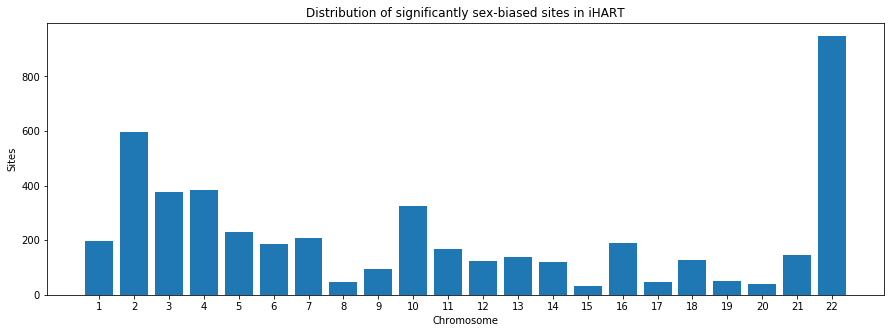

In [448]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(chroms)), [len([x for x in ihart_indices if positions_of_interest[x][0] == chrom]) for chrom in chroms])
plt.xticks(range(len(chroms)), chroms)
plt.title('Distribution of significantly sex-biased sites in iHART')
plt.xlabel('Chromosome')
plt.ylabel('Sites')
plt.plot()

[]

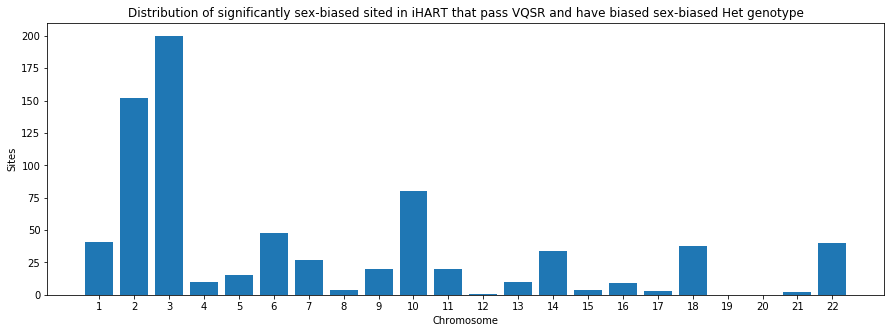

In [449]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(chroms)), 
        [len([x for x in ihart_indices_pass if positions_of_interest[x][0] == chrom]) for chrom in chroms])
plt.xticks(range(len(chroms)), chroms)
plt.title('Distribution of significantly sex-biased sited in iHART that pass VQSR and have biased sex-biased Het genotype')
plt.xlabel('Chromosome')
plt.ylabel('Sites')
plt.plot()


In [450]:
# figure out ticks for ihart_indices_pass
first_chrom_app = []
for chrom in chroms:
    poss = [i for i, x in enumerate(ihart_indices_pass) if positions_of_interest[x][0]==chrom]
    if len(poss) == 0:
        first_chrom_app.append(first_chrom_app[-1])
    else:
        first_chrom_app.append(min(poss))
    

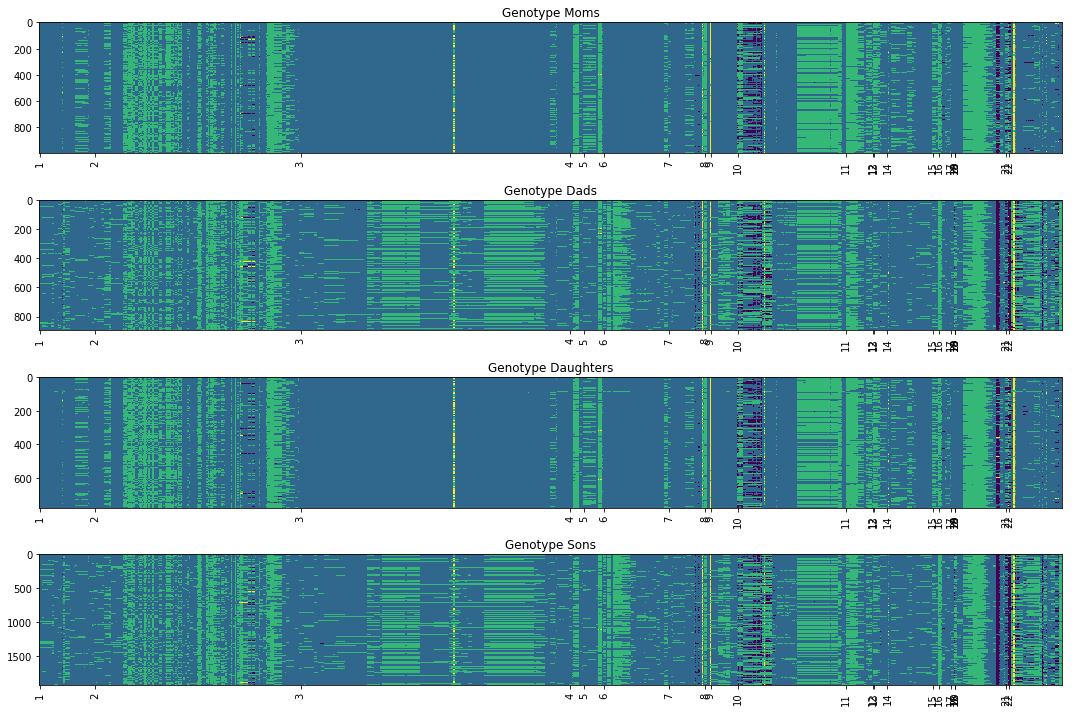

In [451]:
# genotype

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.imshow(ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)], aspect='auto')
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Genotype Moms')

plt.subplot(4, 1, 2)
plt.imshow(ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)], aspect='auto')
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Genotype Dads')

plt.subplot(4, 1, 3)
plt.imshow(ihart_gt[np.ix_(list(ihart_daughter_indices), ihart_indices_pass)], aspect='auto')
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Genotype Daughters')

plt.subplot(4, 1, 4)
plt.imshow(ihart_gt[np.ix_(list(ihart_son_indices), ihart_indices_pass)], aspect='auto')
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Genotype Sons')

plt.tight_layout()
plt.show()

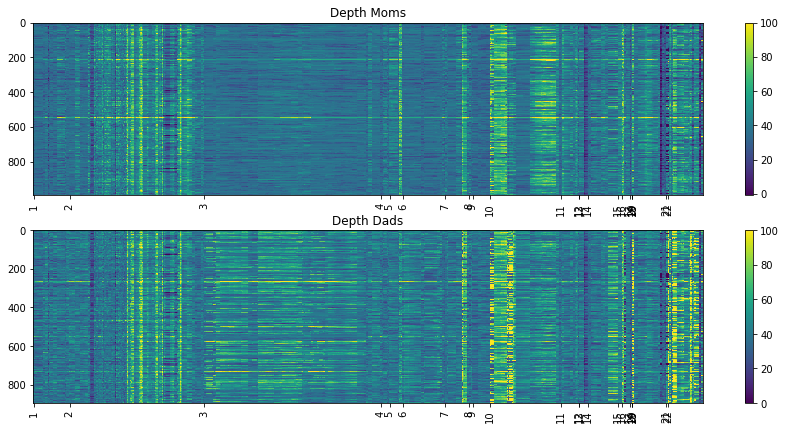

In [452]:
# depth

plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(ihart_dp[np.ix_(list(ihart_mom_indices), ihart_indices_pass)], aspect='auto', vmax=100)
plt.colorbar()
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Depth Moms')

plt.subplot(2, 1, 2)
plt.imshow(ihart_dp[np.ix_(list(ihart_dad_indices), ihart_indices_pass)], aspect='auto', vmax=100)
plt.colorbar()
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Depth Dads')

plt.show()

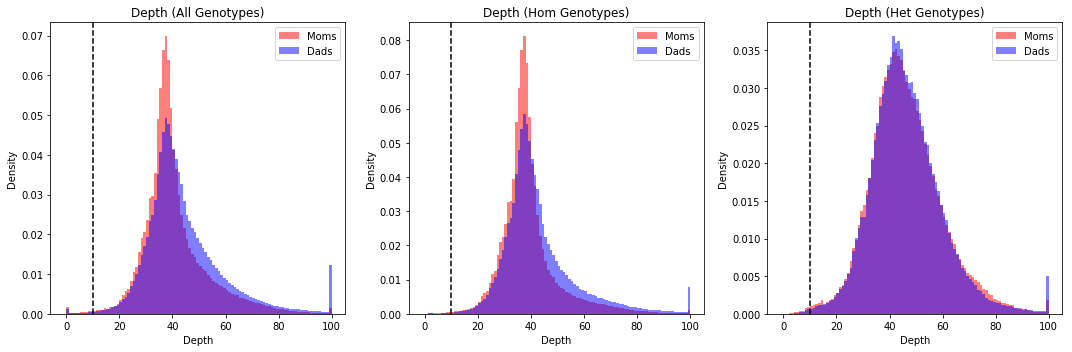

In [469]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(np.clip(ihart_dp[np.ix_(list(ihart_mom_indices), ihart_indices_pass)], -1, 100).flatten(), 
         bins=range(-1, 101), density=True,
         alpha=0.5, color='red', label='Moms')
plt.hist(np.clip(ihart_dp[np.ix_(list(ihart_dad_indices), ihart_indices_pass)], -1, 100).flatten(), 
         bins=range(-1, 101), density=True,
         alpha=0.5, color='blue', label='Dads')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Depth (All Genotypes)')
plt.axvline(10, linestyle='--', color='black')

plt.subplot(1, 3, 2)
a = ihart_dp[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
plt.hist(np.clip(a[b==0], -1, 100), 
         bins=range(-1, 101), density=True,
         alpha=0.5, color='red', label='Moms')
a = ihart_dp[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
plt.hist(np.clip(a[b==0], -1, 100), 
         bins=range(-1, 101), density=True,
         alpha=0.5, color='blue', label='Dads')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Depth (Hom Genotypes)')
plt.axvline(10, linestyle='--', color='black')

plt.subplot(1, 3, 3)
a = ihart_dp[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
plt.hist(np.clip(a[b==1], -1, 100), 
         bins=range(-1, 101), density=True,
         alpha=0.5, color='red', label='Moms')
a = ihart_dp[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
plt.hist(np.clip(a[b==1], -1, 100), 
         bins=range(-1, 101), density=True,
         alpha=0.5, color='blue', label='Dads')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Depth (Het Genotypes)')
plt.axvline(10, linestyle='--', color='black')

plt.tight_layout()
plt.show()

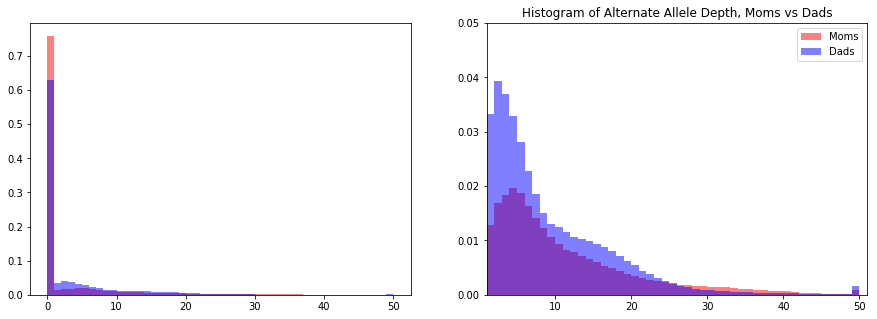

In [420]:
ihart_ad_ref = ihart_ad[:, :, 0]
ihart_ad_alt = ihart_ad[:, :, 1]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(np.clip(ihart_ad_alt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)], -1, 50).flatten(), 
         bins=range(0, 51), density=True,
         alpha=0.5, color='red', label='Moms')
plt.hist(np.clip(ihart_ad_alt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)], -1, 50).flatten(), 
         bins=range(0, 51), density=True,
         alpha=0.5, color='blue', label='Dads')

plt.subplot(1, 2, 2)
plt.hist(np.clip(ihart_ad_alt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)], -1, 50).flatten(), 
         bins=range(0, 51), density=True,
         alpha=0.5, color='red', label='Moms')
plt.hist(np.clip(ihart_ad_alt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)], -1, 50).flatten(), 
         bins=range(0, 51), density=True,
         alpha=0.5, color='blue', label='Dads')
plt.xlim([1, 51])
plt.ylim([0, 0.05])
plt.legend()
plt.title('Histogram of Alternate Allele Depth, Moms vs Dads')
plt.show()

In [421]:
a = ihart_ad_alt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)].flatten()
b = ihart_ad_ref[np.ix_(list(ihart_mom_indices), ihart_indices_pass)].flatten() + ihart_ad_alt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)].flatten()
c = np.asarray([-1 if y==0 else x/y for x, y in zip(a, b)])
print(a.shape, b.shape, a, b, c)


(754968,) (754968,) [0 0 0 ... 0 0 0] [21 21 31 ... 16  6  9] [0. 0. 0. ... 0. 0. 0.]


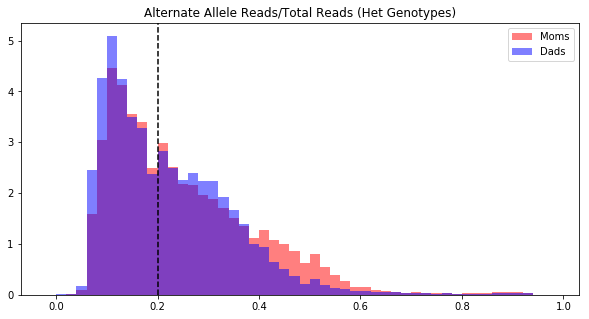

In [474]:
ihart_ad_ref = ihart_ad[:, :, 0]
ihart_ad_alt = ihart_ad[:, :, 1]

plt.figure(figsize=(10, 5))

a = ihart_ad_alt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
b = ihart_ad_ref[np.ix_(list(ihart_mom_indices), ihart_indices_pass)] + ihart_ad_alt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
c = np.asarray([-.01 if y==0 else x/y for x, y in zip(a[ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)] == 1].flatten(),
                                                    b[ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)] == 1].flatten())])
plt.hist(c, bins=np.arange(-0.02, 1, 0.02), density=True, alpha=0.5, color='red', label='Moms')

a = ihart_ad_alt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
b = ihart_ad_ref[np.ix_(list(ihart_dad_indices), ihart_indices_pass)] + ihart_ad_alt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
c = np.asarray([-.01 if y==0 else x/y for x, y in zip(a[ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)] == 1].flatten(),
                                                    b[ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)] == 1].flatten())])
plt.hist(c, bins=np.arange(-0.02, 1, 0.02), density=True, alpha=0.5, color='blue', label='Dads')

plt.axvline(0.2, linestyle='--', color='black')
plt.legend()
plt.title('Alternate Allele Reads/Total Reads (Het Genotypes)')
plt.show()



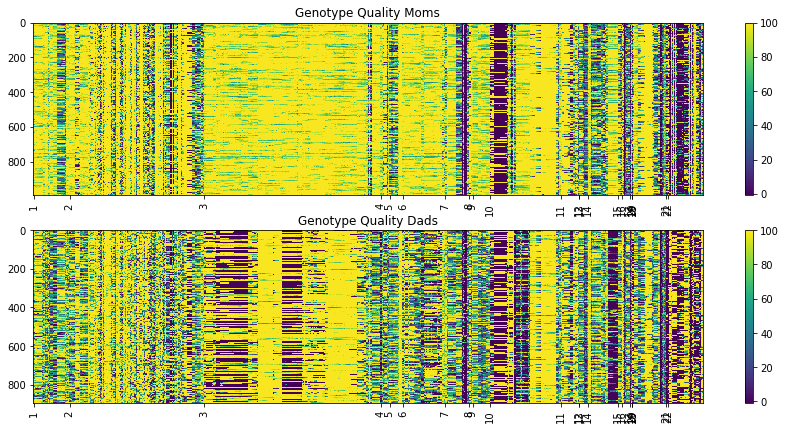

In [424]:
# genotype quality

plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(ihart_gq[np.ix_(list(ihart_mom_indices), ihart_indices_pass)], aspect='auto', vmax=100)
plt.colorbar()
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Genotype Quality Moms')

plt.subplot(2, 1, 2)
plt.imshow(ihart_gq[np.ix_(list(ihart_dad_indices), ihart_indices_pass)], aspect='auto', vmax=100)
plt.colorbar()
plt.xticks(first_chrom_app, chroms, rotation=90)
plt.title('Genotype Quality Dads')

plt.show()

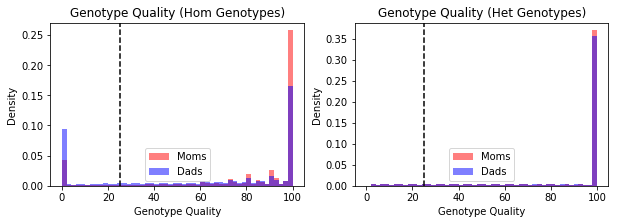

In [482]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
a = ihart_gq[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
plt.hist(a[b==0], 
         bins=range(0, 101, 2), density=True,
         alpha=0.5, color='red', label='Moms')
a = ihart_gq[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
plt.hist(a[b==0], 
         bins=range(0, 101, 2), density=True,
         alpha=0.5, color='blue', label='Dads')
plt.legend()
plt.xlabel('Genotype Quality')
plt.ylabel('Density')
plt.title('Genotype Quality (Hom Genotypes)')
plt.axvline(25, linestyle='--', color='black')

plt.subplot(1, 2, 2)
a = ihart_gq[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]
plt.hist(a[b==1], 
         bins=range(0, 101, 2), density=True,
         alpha=0.5, color='red', label='Moms')
a = ihart_gq[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
b = ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]
plt.hist(a[b==1], 
         bins=range(0, 101, 2), density=True,
         alpha=0.5, color='blue', label='Dads')
plt.legend()
plt.xlabel('Genotype Quality')
plt.ylabel('Density')
plt.title('Genotype Quality (Het Genotypes)')
plt.axvline(25, linestyle='--', color='black')
plt.show()

In [458]:
# depth >= 10, alt_allele_depth/total_reads>=0.2, gq>=25
ihart_filter = (ihart_dp>=10) & (ihart_gq>=25)

for i, j in zip(*np.where(ihart_filter)):
    if (ihart_gt[i, j] == 1 or ihart_gt[i, j] == 2) and ihart_ad[i, j, 1]/ihart_dp[i, j] < 0.2:
        ihart_filter[i, j] = False


In [459]:
print('iHART pass filter, all', np.sum(ihart_filter[:, ihart_indices_pass])/np.sum(ihart_gt[:, ihart_indices_pass]!=-1), np.sum(ihart_filter[:, ihart_indices_pass]))
print('iHART pass filter, mom', np.sum(ihart_filter[np.ix_(list(ihart_mom_indices), ihart_indices_pass)])/np.sum(ihart_gt[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]!=-1), np.sum(ihart_filter[np.ix_(list(ihart_mom_indices), ihart_indices_pass)]))
print('iHART pass filter, dad', np.sum(ihart_filter[np.ix_(list(ihart_dad_indices), ihart_indices_pass)])/np.sum(ihart_gt[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]!=-1), np.sum(ihart_filter[np.ix_(list(ihart_dad_indices), ihart_indices_pass)]))

print('iHART pass filter, all', np.sum(ihart_filter[:, ihart_indices_pass]))



iHART pass filter, all 0.7208767311267751 2479524
iHART pass filter, mom 0.807527693856999 603010
iHART pass filter, dad 0.6686458616173693 445720
iHART pass filter, all 2479524


In [460]:
has_bad_genotypes = np.where(np.any(ihart_filter[:, ihart_indices_pass], axis=0))[0]
print(len(has_bad_genotypes))

ihart_all_nearby_genes = set(sum([ihart_nearby_genes[i] for i in has_bad_genotype if ihart_nearby_genes[i] is not None], []))
print(len(ihart_all_nearby_genes))


758
340


In [461]:
import csv

sfari_genes = [[], [], [], [], [], [], []]

with open('../data/SFARI_autism_genes.csv', 'r') as f:
    next(f) # skip header
    data = csv.reader(f)
    for pieces in data:
        gene = pieces[1]
        score = 7 if pieces[5]=='' else int(pieces[5])
        sfari_genes[score-1].append(gene)

In [462]:
print([len(x) for x in sfari_genes])

[25, 62, 195, 454, 175, 25, 118]


In [463]:
for i in range(6):
    overlap = ihart_all_nearby_genes & set(sfari_genes[i])
    print('SFARI level %d: %d %s' % (i+1, len(overlap), str(overlap)))
    
overlap = ihart_all_nearby_genes & set(sfari_genes[6])
print('SFARI level ?: %d %s' % (len(overlap), str(overlap)))

SFARI level 1: 0 set()
SFARI level 2: 2 {'GRIA1', 'KAT2B'}
SFARI level 3: 3 {'CEP135', 'PYHIN1', 'DPP10'}
SFARI level 4: 4 {'STK39', 'PTGS2', 'GRID2', 'LRBA'}
SFARI level 5: 7 {'CLSTN2', 'ERBB4', 'GAP43', 'GABRB1', 'ROBO1', 'ESR1', 'RBMS3'}
SFARI level 6: 1 {'SUCLG2'}
SFARI level ?: 4 {'NSD1', 'HCN1', 'SCN7A', 'SDK1'}


# Let's compare genotype concordance for same-sex and different-sex sibpairs

In [288]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
family_to_individuals = dict()

with open('%s/chr.%s.gen.samples.txt' % (ihart_data_dir, chroms[0]), 'r') as f:
    sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex
                
                if f_id != '0' and m_id != '0':
                    if (fam_id, m_id, f_id) not in family_to_individuals:
                        family_to_individuals[(fam_id, m_id, f_id)] = [m_id, f_id]
                    family_to_individuals[(fam_id, m_id, f_id)].append(child_id)
                    

In [307]:
same_sex_match = np.zeros((n,), dtype=int)
same_sex_male_match = np.zeros((n,), dtype=int)
same_sex_female_match = np.zeros((n,), dtype=int)

diff_sex_match = np.zeros((n,), dtype=int)
num_same_sex, num_diff_sex = 0, 0
num_same_sex_male, num_same_sex_female = 0, 0

for individuals in family_to_individuals.values():
    for child1 in individuals[2:]:
        for child2 in individuals[2:]:
            if child1 < child2 and child1 in sample_id_to_index and child2 in sample_id_to_index:
                sex1, sex2 = child_id_to_sex[child1], child_id_to_sex[child2]
                index1, index2 = sample_id_to_index[child1], sample_id_to_index[child2]
                if (sex1 == '1' and sex2 == '1') or (sex1 == '2' and sex2 == '2'):
                    num_same_sex += 1
                    same_sex_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1
                    
                    if sex1 == '1':
                        num_same_sex_male += 1
                        same_sex_male_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1
                    else:
                        num_same_sex_female += 1
                        same_sex_female_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1
                    
                elif (sex1 == '1' and sex2 == '2') or (sex1 == '2' and sex2 == '1'):
                    num_diff_sex += 1
                    diff_sex_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1


In [308]:
import random

same_sex_match_all = np.zeros((n,), dtype=int)
same_sex_male_match_all = np.zeros((n,), dtype=int)
same_sex_female_match_all = np.zeros((n,), dtype=int)

diff_sex_match_all = np.zeros((n,), dtype=int)
num_same_sex_all, num_diff_sex_all = 0, 0
num_same_sex_male_all, num_same_sex_female_all = 0, 0

children_subset = [random.choice(inds[2:]) for inds in family_to_individuals.values()]
for child1 in children_subset:
    for child2 in children_subset:
        if child1 < child2 and child1 in sample_id_to_index and child2 in sample_id_to_index:
            sex1, sex2 = child_id_to_sex[child1], child_id_to_sex[child2]
            index1, index2 = sample_id_to_index[child1], sample_id_to_index[child2]
            indices = ihart_gt[index1, :] == ihart_gt[index2, :]
            
            if (sex1 == '1' and sex2 == '1') or (sex1 == '2' and sex2 == '2'):
                num_same_sex_all += 1
                same_sex_match_all[indices] += 1
                
                if sex1 == '1':
                    num_same_sex_male_all += 1
                    same_sex_male_match_all[indices] += 1
                else:
                    num_same_sex_female_all += 1
                    same_sex_female_match_all[indices] += 1
                    
            elif (sex1 == '1' and sex2 == '2') or (sex1 == '2' and sex2 == '1'):
                num_diff_sex_all += 1
                diff_sex_match_all[indices] += 1


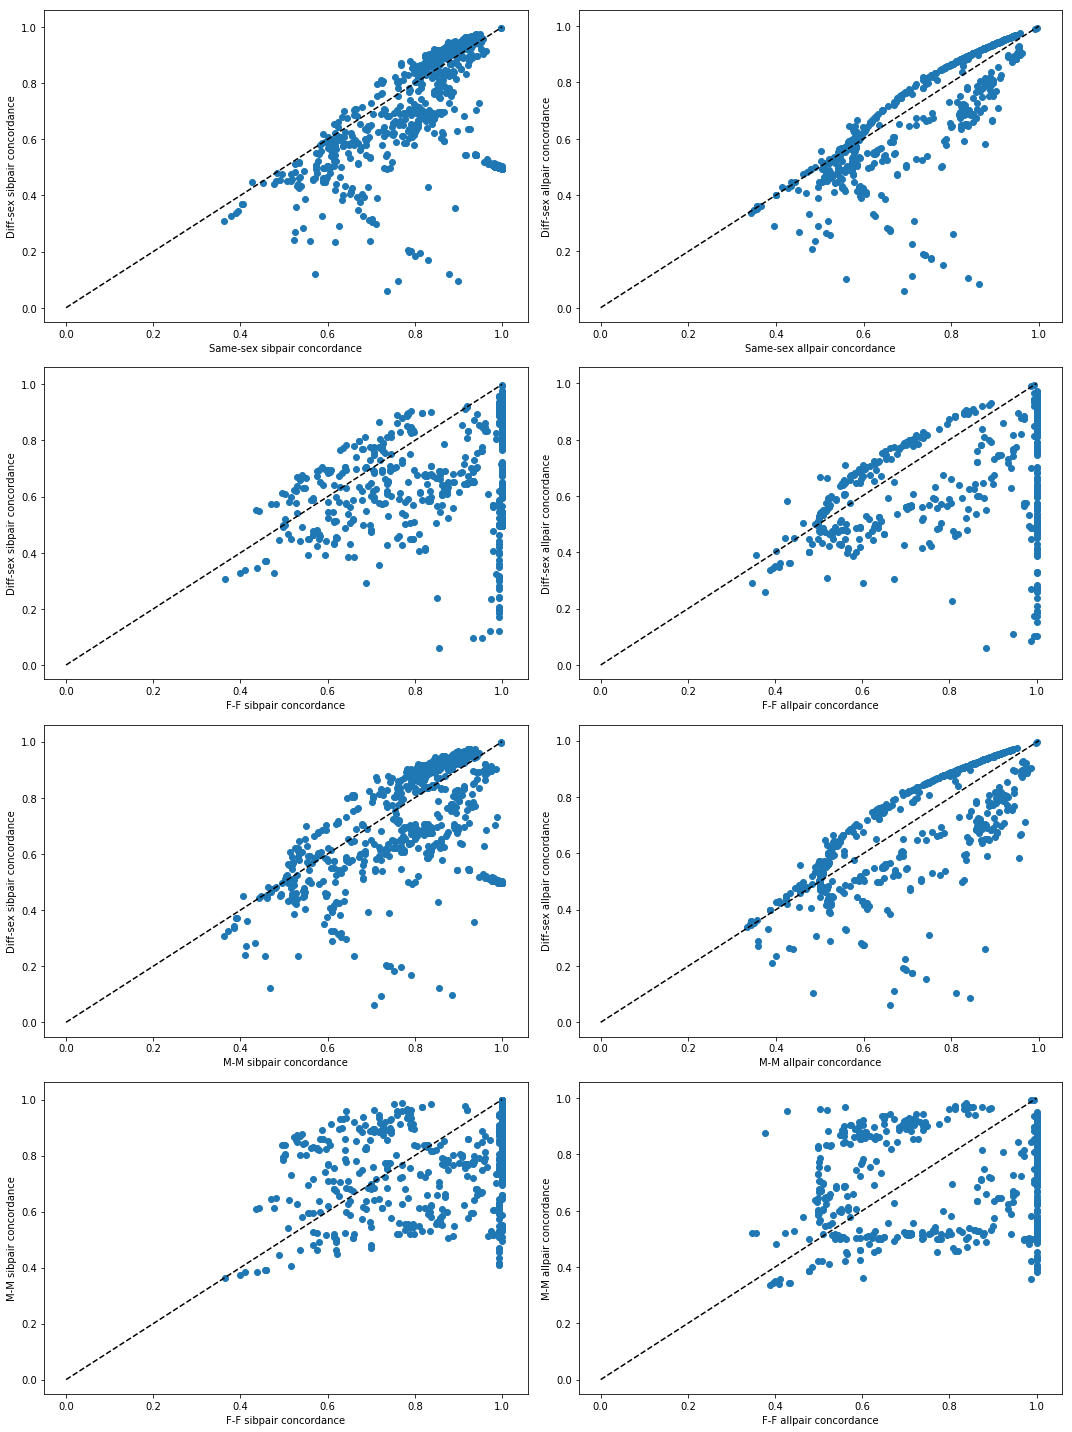

In [312]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
plt.scatter(same_sex_match[ihart_indices_pass]/num_same_sex, diff_sex_match[ihart_indices_pass]/num_diff_sex)
plt.xlabel('Same-sex sibpair concordance')
plt.ylabel('Diff-sex sibpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 2)
plt.scatter(same_sex_match_all[ihart_indices_pass]/num_same_sex_all, diff_sex_match_all[ihart_indices_pass]/num_diff_sex_all)
plt.xlabel('Same-sex allpair concordance')
plt.ylabel('Diff-sex allpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 3)
plt.scatter(same_sex_female_match[ihart_indices_pass]/num_same_sex_female, diff_sex_match[ihart_indices_pass]/num_diff_sex)
plt.xlabel('F-F sibpair concordance')
plt.ylabel('Diff-sex sibpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 4)
plt.scatter(same_sex_female_match_all[ihart_indices_pass]/num_same_sex_female_all, diff_sex_match_all[ihart_indices_pass]/num_diff_sex_all)
plt.xlabel('F-F allpair concordance')
plt.ylabel('Diff-sex allpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 5)
plt.scatter(same_sex_male_match[ihart_indices_pass]/num_same_sex_male, diff_sex_match[ihart_indices_pass]/num_diff_sex)
plt.xlabel('M-M sibpair concordance')
plt.ylabel('Diff-sex sibpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 6)
plt.scatter(same_sex_male_match_all[ihart_indices_pass]/num_same_sex_male_all, diff_sex_match_all[ihart_indices_pass]/num_diff_sex_all)
plt.xlabel('M-M allpair concordance')
plt.ylabel('Diff-sex allpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 7)
plt.scatter(same_sex_female_match[ihart_indices_pass]/num_same_sex_female, same_sex_male_match[ihart_indices_pass]/num_same_sex_male)
plt.xlabel('F-F sibpair concordance')
plt.ylabel('M-M sibpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(4, 2, 8)
plt.scatter(same_sex_female_match_all[ihart_indices_pass]/num_same_sex_female_all, same_sex_male_match_all[ihart_indices_pass]/num_same_sex_male_all)
plt.xlabel('F-F allpair concordance')
plt.ylabel('M-M allpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.tight_layout()
plt.show()

In [330]:
# we want to look at family concordance vs sex concordance

sibpair_match = np.zeros((n,), dtype=int)
femalepair_match = np.zeros((n,), dtype=int)
malepair_match = np.zeros((n,), dtype=int)

num_sibpairs, num_femalepairs, num_malepairs = 0, 0, 0

for individuals in family_to_individuals.values():
    for child1 in individuals[2:]:
        for child2 in individuals[2:]:
            if child1 < child2 and child1 in sample_id_to_index and child2 in sample_id_to_index:
                index1, index2 = sample_id_to_index[child1], sample_id_to_index[child2]
                sex1, sex2 = child_id_to_sex[child1], child_id_to_sex[child2]
                
                if (sex1 == '1' and sex2 == '2') or (sex1 == '2' and sex2 == '1'):
                    sibpair_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1
                    num_sibpairs += 1
        

for fam1, inds1 in family_to_individuals.items():
    daughters1 = [x for x in inds1[2:] if child_id_to_sex[x] == '2' and x in sample_id_to_index]
    sons1 = [x for x in inds1[2:] if child_id_to_sex[x] == '1' and x in sample_id_to_index]
    for fam2, inds2 in family_to_individuals.items():
        if fam1 < fam2:
            daughters2 = [x for x in inds2[2:] if child_id_to_sex[x] == '2' and x in sample_id_to_index]
            sons2 = [x for x in inds2[2:] if child_id_to_sex[x] == '1' and x in sample_id_to_index]
            
            if len(daughters1) > 0 and len(daughters2) > 0:
                index1, index2 = sample_id_to_index[random.choice(daughters1)], sample_id_to_index[random.choice(daughters2)]
                femalepair_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1  
                num_femalepairs += 1
                
            if len(sons1) > 0 and len(sons2) > 0:
                index1, index2 = sample_id_to_index[random.choice(sons1)], sample_id_to_index[random.choice(sons2)]
                malepair_match[ihart_gt[index1, :] == ihart_gt[index2, :]] += 1  
                num_malepairs += 1


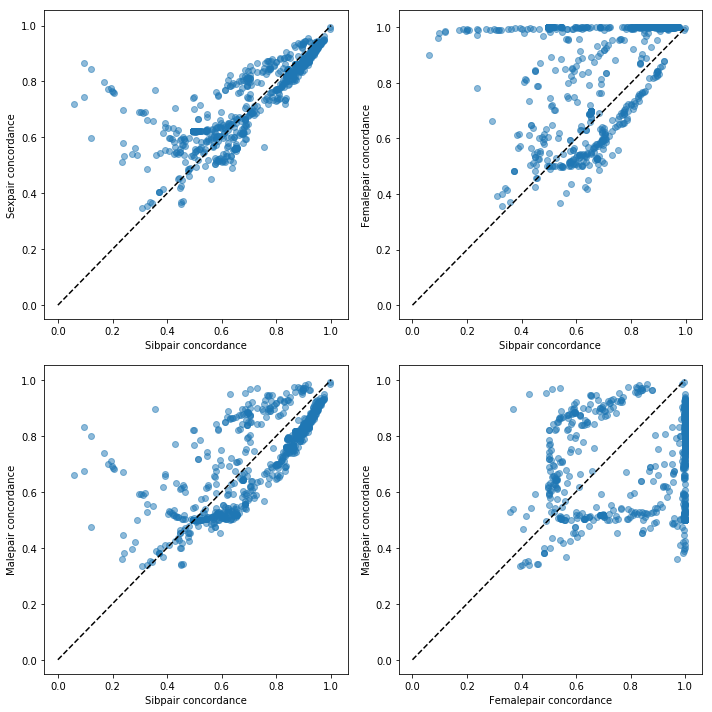

In [331]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(sibpair_match[ihart_indices_pass]/num_sibpairs, 
            (malepair_match[ihart_indices_pass]+femalepair_match[ihart_indices_pass])/(num_femalepairs+num_malepairs), alpha=0.5)
plt.xlabel('Sibpair concordance')
plt.ylabel('Sexpair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(2, 2, 2)
plt.scatter(sibpair_match[ihart_indices_pass]/num_sibpairs, 
            femalepair_match[ihart_indices_pass]/num_femalepairs, alpha=0.5)
plt.xlabel('Sibpair concordance')
plt.ylabel('Femalepair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(2, 2, 3)
plt.scatter(sibpair_match[ihart_indices_pass]/num_sibpairs, 
            malepair_match[ihart_indices_pass]/num_malepairs, alpha=0.5)
plt.xlabel('Sibpair concordance')
plt.ylabel('Malepair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(2, 2, 4)
plt.scatter(femalepair_match[ihart_indices_pass]/num_femalepairs, 
            malepair_match[ihart_indices_pass]/num_malepairs, alpha=0.5)
plt.xlabel('Femalepair concordance')
plt.ylabel('Malepair concordance')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.tight_layout()
plt.show()


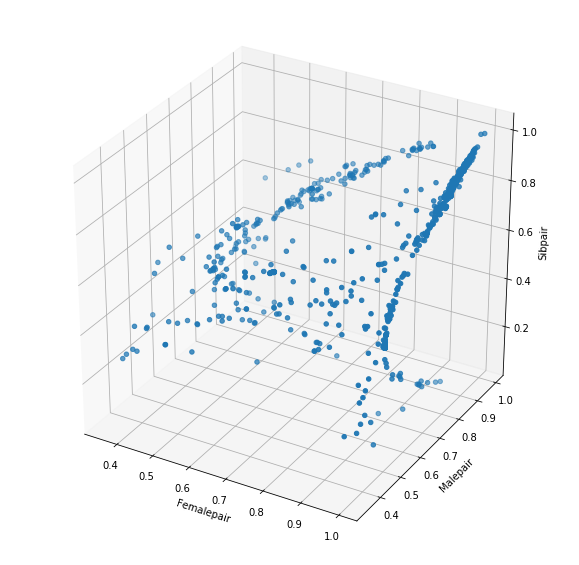

In [332]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(femalepair_match[ihart_indices_pass]/num_femalepairs, 
            malepair_match[ihart_indices_pass]/num_malepairs,
           sibpair_match[ihart_indices_pass]/num_sibpairs)
ax.set_xlabel('Femalepair')
ax.set_ylabel('Malepair')
ax.set_zlabel('Sibpair')
plt.show()

In [333]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=femalepair_match[ihart_indices_pass]/num_femalepairs,
    y=malepair_match[ihart_indices_pass]/num_malepairs,
    z=sibpair_match[ihart_indices_pass]/num_sibpairs,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [345]:
# we want to look at family concordance vs sex concordance

daughter_mom_match = np.zeros((n,), dtype=int)
daughter_dad_match = np.zeros((n,), dtype=int)
son_mom_match = np.zeros((n,), dtype=int)
son_dad_match = np.zeros((n,), dtype=int)

daughter_random_match = np.zeros((n,), dtype=int)
son_random_match = np.zeros((n,), dtype=int)

num_daughters, num_sons = 0, 0

for individuals in family_to_individuals.values():
    for child1 in individuals[2:]:
        if child1 in sample_id_to_index:
            index1 = sample_id_to_index[child1]
            if child_id_to_sex[child1] == '2':
                # female child
                if individuals[0] in sample_id_to_index and individuals[1] in sample_id_to_index:
                    mom_index = sample_id_to_index[individuals[0]]
                    daughter_mom_match[ihart_gt[index1, :] == ihart_gt[mom_index, :]] += 1
                    dad_index = sample_id_to_index[individuals[1]]
                    daughter_dad_match[ihart_gt[index1, :] == ihart_gt[dad_index, :]] += 1

                    not_mom_index = -1
                    while not_mom_index == -1:
                        not_mom_id = random.choice(list(family_to_individuals.values()))[0]
                        if not_mom_id in sample_id_to_index:
                            not_mom_index = sample_id_to_index[not_mom_id]
                    daughter_random_match[ihart_gt[index1, :] == ihart_gt[not_mom_index, :]] += 1
                    num_daughters += 1
            elif child_id_to_sex[child1] == '1':
                # male child
                if individuals[0] in sample_id_to_index and individuals[1] in sample_id_to_index:
                    mom_index = sample_id_to_index[individuals[0]]
                    son_mom_match[ihart_gt[index1, :] == ihart_gt[mom_index, :]] += 1
                    dad_index = sample_id_to_index[individuals[1]]
                    son_dad_match[ihart_gt[index1, :] == ihart_gt[dad_index, :]] += 1

                    not_dad_index = -1
                    while not_dad_index == -1:
                        not_dad_id = random.choice(list(family_to_individuals.values()))[1]
                        if not_dad_id in sample_id_to_index:
                            not_dad_index = sample_id_to_index[not_dad_id]
                    son_random_match[ihart_gt[index1, :] == ihart_gt[not_dad_index, :]] += 1
                    num_sons += 1
              

646 1646


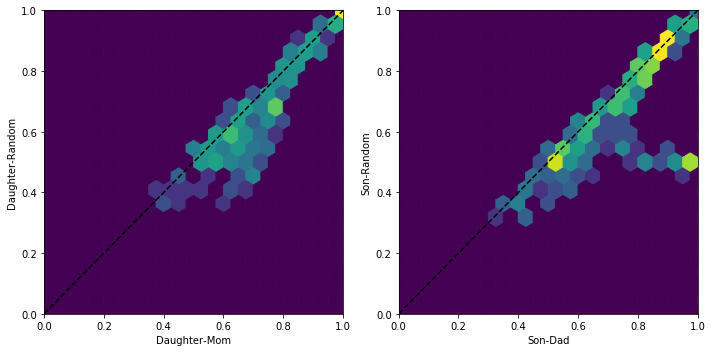

In [379]:
print(num_daughters, num_sons)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
#plt.scatter(daughter_mom_match/num_daughters, daughter_random_match/num_daughters, alpha=0.5)
plt.hexbin(daughter_mom_match[ihart_indices_pass]/num_daughters, 
           daughter_random_match[ihart_indices_pass]/num_daughters,
           bins='log', gridsize=20, extent=(0, 1, 0, 1), vmax=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Daughter-Mom')
plt.ylabel('Daughter-Random')

plt.subplot(1, 2, 2)
#plt.scatter(son_dad_match/num_sons, son_random_match/num_sons, alpha=0.5)
plt.hexbin(son_dad_match[ihart_indices_pass]/num_sons, 
           son_random_match[ihart_indices_pass]/num_sons, 
           bins='log', gridsize=20, extent=(0, 1, 0, 1), vmax=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
#plt.colorbar()
plt.xlabel('Son-Dad')
plt.ylabel('Son-Random')

plt.tight_layout()
plt.show()

In [ ]:
print(num_daughters, num_sons)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
#plt.scatter(daughter_mom_match/num_daughters, daughter_dad_match/num_daughters, alpha=0.5)
plt.hexbin(daughter_mom_match[ihart_indices_pass]/num_daughters, 
           daughter_dad_match[ihart_indices_pass]/num_daughters, 
           bins='log', gridsize=20, extent=(0, 1, 0, 1), vmax=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Daughter-Mom')
plt.ylabel('Daughter-Dad')

plt.subplot(1, 3, 2)
#plt.scatter(son_dad_match/num_sons, son_mom_match/num_sons, alpha=0.5)
plt.hexbin(son_dad_match[ihart_indices_pass]/num_sons, 
           son_mom_match[ihart_indices_pass]/num_sons, 
           bins='log', gridsize=20, extent=(0, 1, 0, 1), vmax=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Son-Dad')
plt.ylabel('Son-Mom')

plt.subplot(1, 3, 3)
plt.hexbin(daughter_mom_match[ihart_indices_pass]/num_daughters, 
           son_dad_match[ihart_indices_pass]/num_sons, 
           bins='log', gridsize=20, extent=(0, 1, 0, 1), vmax=2)
#plt.colorbar()
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Daughter-Mom')
plt.ylabel('Son-Dad')

plt.tight_layout()
plt.show()



In [396]:
# TDT

mom_TDT = np.zeros((n, 2, 2), dtype=int) #pos, transmited (Y, N), sex (F, M)
dad_TDT = np.zeros((n, 2, 2), dtype=int)

for individuals in family_to_individuals.values():
    if individuals[0] in sample_id_to_index and individuals[1] in sample_id_to_index:
        mom_index, dad_index = sample_id_to_index[individuals[0]], sample_id_to_index[individuals[1]]
        
        mom_indices = np.where((ihart_gt[mom_index, :] == 1) & (ihart_gt[dad_index, :] == 0))[0]
        dad_indices = np.where((ihart_gt[mom_index, :] == 0) & (ihart_gt[dad_index, :] == 1))[0]
        
        for child in individuals[2:]:
            if child in sample_id_to_index and (child_id_to_sex[child] == '1' or child_id_to_sex[child] == '2'):
                child_index = sample_id_to_index[child]
                child_sex = 0 if child_id_to_sex[child] == '2' else 1
                
                mom_TDT[mom_indices, 0, child_sex] += (ihart_gt[child_index, mom_indices] == 1)
                mom_TDT[mom_indices, 1, child_sex] += (ihart_gt[child_index, mom_indices] == 0)
                dad_TDT[dad_indices, 0, child_sex] += (ihart_gt[child_index, dad_indices] == 1)
                dad_TDT[dad_indices, 1, child_sex] += (ihart_gt[child_index, dad_indices] == 0)

In [402]:
from scipy.stats import fisher_exact

mom_logpvalues = np.zeros((n,), dtype=float)
dad_logpvalues = np.zeros((n,), dtype=float)
both_logpvalues = np.zeros((n,), dtype=float)
for i in range(n):
    pvalue = fisher_exact(mom_TDT[i, :, :])[1]
    mom_logpvalues[i] = 400 if pvalue == 0 else -np.log10(pvalue)
    pvalue = fisher_exact(dad_TDT[i, :, :])[1]
    dad_logpvalues[i] = 400 if pvalue == 0 else -np.log10(pvalue)
    pvalue = fisher_exact(mom_TDT[i, :, :]+dad_TDT[i, :, :])[1]
    both_logpvalues[i] = 400 if pvalue == 0 else -np.log10(pvalue)

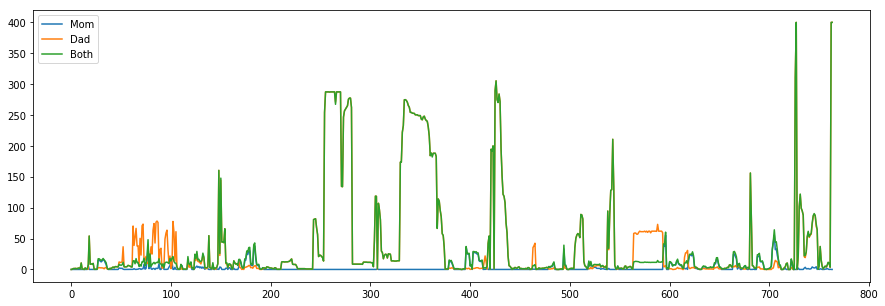

In [407]:
plt.figure(figsize=(15, 5))
plt.plot(mom_logpvalues[ihart_indices_pass], label='Mom')
plt.plot(dad_logpvalues[ihart_indices_pass], label='Dad')
plt.plot(both_logpvalues[ihart_indices_pass], label='Both')
plt.legend()

plt.show()


Mom 76 Dad 296


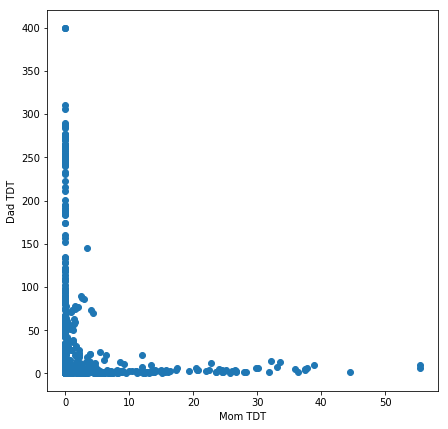

In [411]:
print('Mom', np.sum(mom_logpvalues[ihart_indices_pass]>bonferonni_cutoff),
     'Dad', np.sum(dad_logpvalues[ihart_indices_pass]>bonferonni_cutoff))

plt.figure(figsize=(7, 7))
plt.scatter(mom_logpvalues[ihart_indices_pass], dad_logpvalues[ihart_indices_pass])
plt.xlabel('Mom TDT')
plt.ylabel('Dad TDT')
plt.show()

# Now let's take a look at GVCFs (Before joint genotyping)


In [ ]:
# Pull data from GVCF

def pull_gvcf(dataset, sample_id_to_index, num_chunks):
    
    m = len(sample_id_to_index)
    
    gt = np.zeros((m, n), dtype=int)
    dp = np.zeros((m, n), dtype=int)
    ad = np.zeros((m, n, 2), dtype=int)
    gq = np.zeros((m, n), dtype=int)
    
    for chrom in chroms:
        print(chrom, end=' ')
        for chunk in range(num_chunks):
            with gzip.open('%s/sex_gwas_%s%s.%s.vcf.gz' % (data_of_interest, dataset, chrom, str(chunk).zfill(2)), 'rt') as f:

                # skip header
                line = next(f)
                while line.startswith('##'):
                    line = next(f)

                sample_indices = [sample_id_to_index[x] for x in line.strip().split('\t')[9:]]

                for line in f:
                    pieces = line.strip().split('\t')
                    chrom, pos, _, ref, alt, _, pa  = pieces[:7]
                    is_biallelic_snp = True if len(ref) == 1 and len(alt) == 1 and ref != '.' and alt != '.' else False

                    if is_biallelic_snp:
                        i = pos_to_index[(chrom, int(pos))]

                        format_map = dict([(x, i) for i, x in enumerate(pieces[8].strip().split(':'))])
                        for j, entry in zip(sample_indices, pieces[9:]):
                            entry_pieces = entry.split(':')
                            gt[j, i] = convert_gt(entry_pieces[format_map['GT']])
                            dp[j, i] = convert_dp(entry_pieces[format_map['DP']])
                            ad[j, i, :] = convert_ad(entry_pieces[format_map['AD']])  
                            gq[j, i] = convert_gq(entry_pieces[format_map['GQ']])
    return is_pass, gt, dp, ad, gq, nearby_genes
   
ihart_participant_id_to_index = dict()
with gzip.open('%s/sex_gwas_%s%s.vcf.gz' % (data_of_interest, dataset, chroms[0]), 'rt') as f:
        # skip header
        line = next(f)
        while line.startswith('##'):
            line = next(f)
        m = len(line.strip().split('\t'))-9
        
ihart_sample_id_to_index = dict()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ihart_sample_id_to_index[1]
        
ihart_is_pass, ihart_gt, ihart_dp, ihart_ad, ihart_gq, ihart_nearby_genes = pull_gvcf('ihart', ihart_sample_id_to_index, 47)                
                